In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [25]:
# We import the model
model = WCModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 100.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,:] = 0.7
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]

# We set the duration of the simulation and the initial values
model.params["duration"] = duration

# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.params.exc_init = np.array([[0.17258623779163518]])
model.params.exc_init = np.array([[0.07601243884401115]])
model.run()
te = model.exc[0,-1]
ti = model.inh[0,-1]

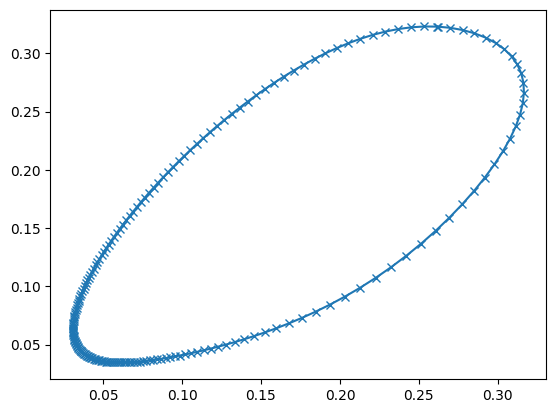

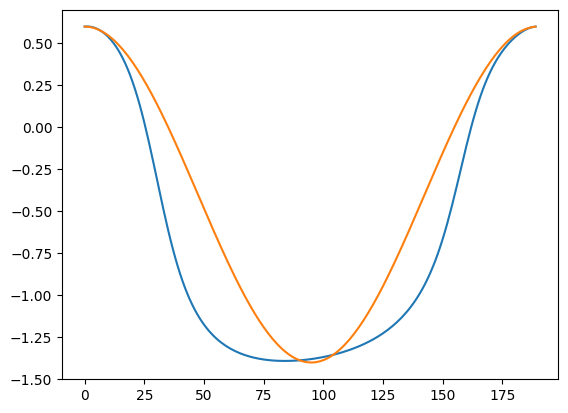

84 95


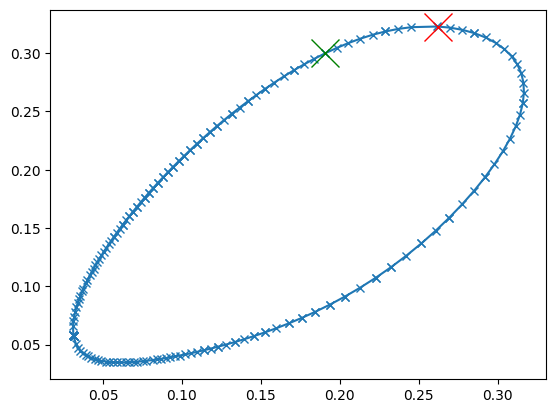

In [44]:
# We import the model
model = WCModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 100.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,:] = 1.
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]

# We set the duration of the simulation and the initial values
model.params["duration"] = duration

# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.params.exc_init = np.array([[0.17258623779163518]])
model.params.exc_init = np.array([[0.07601243884401115]])
model.run()

state = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)

peaks = scipy.signal.find_peaks(model.exc[0,-500:])[0]
period = dt * (peaks[-1] - peaks[-2])

#plot_oc_singlenode(duration, dt, state, target, control)

dur_array = np.arange(duration, duration+period, dt)
init_ellipse = np.zeros((1,4,len(dur_array)))
init_phase = np.zeros((1, len(dur_array)))
for t in range(len(dur_array)):
    d = dur_array[t]
    model.params.duration = d
    model.run()
    hilb = scipy.signal.hilbert(model.exc[0,:])[-1]
    init_phase[0,t] = np.arctan2(hilb.imag, hilb.real)

    init_ellipse[0,0,t] = model.exc[0,-1]
    init_ellipse[0,1,t] = model.inh[0,-1]

plt.plot(init_ellipse[0,0,:], init_ellipse[0,1,:], marker='x')
plt.show()

phase_mapped = np.cos(2.*np.pi*np.arange(0,len(dur_array),1)/len(dur_array))-(1.-init_phase[0,0])

plt.plot(np.arange(0,len(dur_array),1), init_phase[0,:])
plt.plot(np.arange(0,len(dur_array),1), phase_mapped)
plt.show()

init_ellipse_mapped = np.zeros((init_ellipse.shape))
init_ellipse_mapped[0,:,0] = init_ellipse[0,:,0]

t_break_init = init_phase[0,:].argmin()
t_break_mapped = phase_mapped.argmin()
print(t_break_init, t_break_mapped)

ics = []

for t in range(t_break_mapped):
    idx = (np.abs(init_phase[0,:t_break_init]-phase_mapped[t])).argmin()
    ics.append(idx)

for t in range(t_break_mapped, 2*t_break_mapped,1):
    idx = (np.abs(init_phase[0,t_break_init:]-phase_mapped[t])).argmin()
    ics.append(idx + t_break_init)


ellipse_mapped = np.zeros(( init_ellipse[:,:,:len(ics)].shape ))
for t in range(len(ics)):
    idx = ics[t]
    ellipse_mapped[0,:,t] = init_ellipse[0,:,idx]

plt.plot(ellipse_mapped[0,0,:], ellipse_mapped[0,1,:], marker='x')
plt.plot(ellipse_mapped[0,0,0], ellipse_mapped[0,1,0], color='red', markersize=20,marker='x')
plt.plot(ellipse_mapped[0,0,10], ellipse_mapped[0,1,10], color='green', markersize=20,marker='x')
plt.show()

duration = 250.
model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,:] = 1.

# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.params.exc_init = np.array([[0.17258623779163518]])
model.params.exc_init = np.array([[0.07601243884401115]])

model.run()

target_osc = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)

target_down = np.zeros((target_osc.shape))
target_down[0,0,:] = te
target_down[0,1,:] = ti

Compute control for a noisy system
Mean cost in iteration 0: 0.6291820696686001
Mean cost in iteration 25: 0.13361035366196286
Mean cost in iteration 50: 0.13340593550643187
Mean cost in iteration 75: 0.13326546953137222
Mean cost in iteration 100: 0.13371330218053257
Minimal cost found at iteration 79
Final cost validated with 1000 noise realizations : 0.13347873560129556


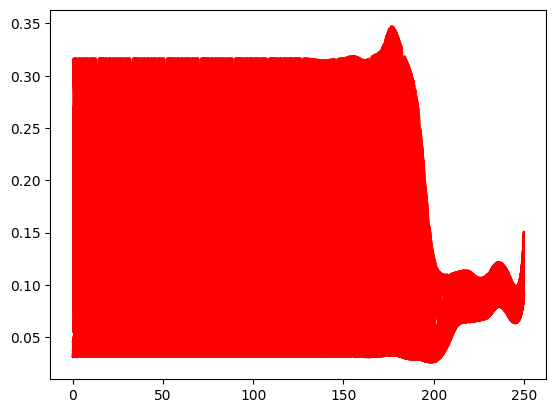

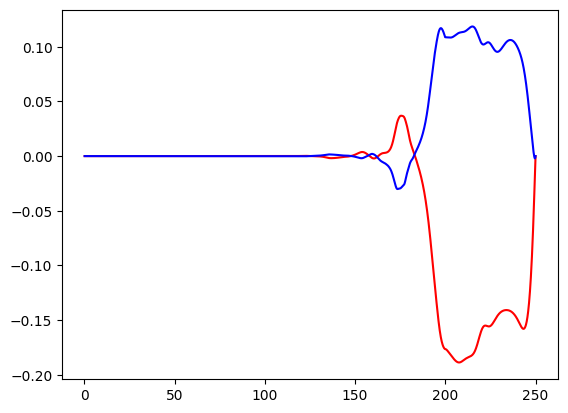

In [71]:
w2=1e-1
M_ = 100

model_controlled = oc_wc.OcWc(model, target_down, w_p=1, w_2=w2, print_array=np.arange(0,501,25), precision_cost_interval=(2000, None), M=M_, M_validation=1000, random_init=init_ellipse)
model_controlled.optimize(100)

states = model_controlled.M_states
control = model_controlled.control

for m in range(len(states)):
    plt.plot(model_controlled.model.t, states[m][0,0,1:], color="red")
    #plt.plot(model_controlled.model.t, states[m][0,1,1:], color="blue")

plt.show()

plt.plot(model_controlled.model.t, control[0,0,1:], color='red')
plt.plot(model_controlled.model.t, control[0,1,1:], color='blue')
plt.show()

In [73]:
def plot_random_init(s, t, c, filename):

    fig, ax = plt.subplots(2,1)
    time = model_controlled.model.t

    for m in range(0, len(s), 20):
        ax[0].plot(time, s[m][0,0,1:])

    ax[0].plot(time, t[0,0,1:], linestyle='--', color='red')
    ax[0].set_xlim(0,duration)
    ax[0].set_ylabel("Excitatory activity")

    ax[1].plot(time, c[0,0,1:], color='red')
    ax[1].plot(time, c[0,1,1:], color='blue')
    ax[1].set_xlim(0,duration)
    ax[1].set_ylabel("Control")

    plt.savefig(filename)
    plt.show()

----------------- 175.0
Compute control for a noisy system
Mean cost in iteration 0: 1.2745189166367823
Minimal cost found at iteration 0
Final cost validated with 1000 noise realizations : 1.2340582364302397
osc_phase_w2_-2_175


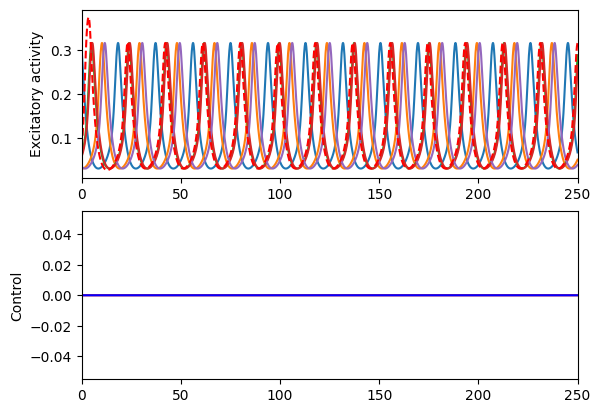

----------------- 180.0
Compute control for a noisy system
Mean cost in iteration 0: 1.1848559925151763
Minimal cost found at iteration 0
Final cost validated with 1000 noise realizations : 1.1696218709884285
osc_phase_w2_-2_180


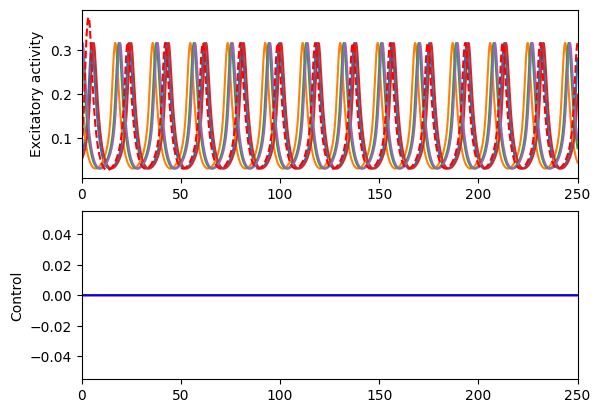

----------------- 185.0
Compute control for a noisy system
Mean cost in iteration 0: 1.064766606241508
Minimal cost found at iteration 0
Final cost validated with 1000 noise realizations : 1.1195360762118503
osc_phase_w2_-2_185


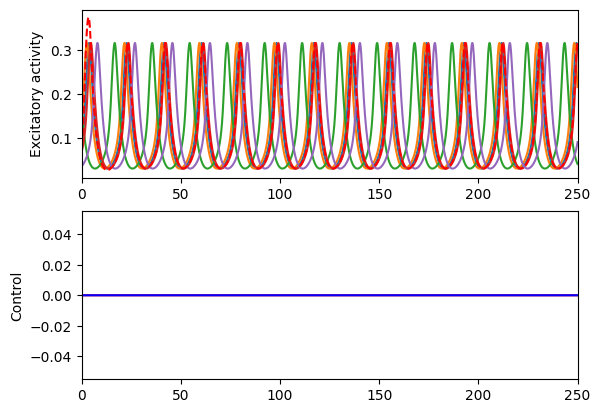

----------------- 190.0
Compute control for a noisy system
Mean cost in iteration 0: 1.0866147018214365
Minimal cost found at iteration 0
Final cost validated with 1000 noise realizations : 1.023851395599552
osc_phase_w2_-2_190


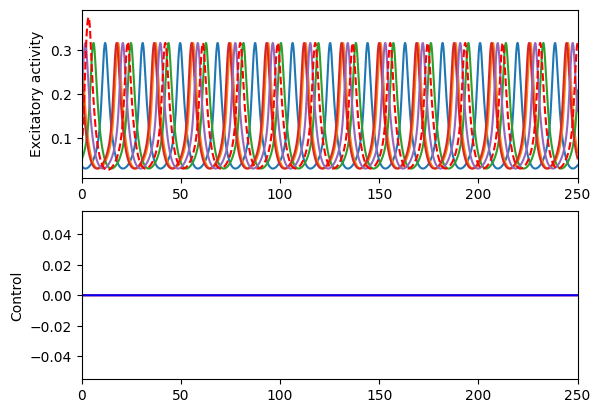

----------------- 195.0
Compute control for a noisy system
Mean cost in iteration 0: 0.8523952620911673
Minimal cost found at iteration 0


KeyboardInterrupt: 

In [78]:
w2=1e-2

for int0 in np.arange(1750, 2001, 50):
    print("-----------------", int0/10)

    model_controlled = oc_wc.OcWc(model, target_osc, w_p=1, w_2=w2, print_array=np.arange(0,501,25), precision_cost_interval=(int0, None), control_matrix = controlmat, M=M_, M_validation=1000, random_init=init_ellipse)
    model_controlled.optimize(400)

    states = model_controlled.M_states
    control = model_controlled.control

    fname = "osc_phase_w2_-2_" + str(int(int0/10)) + ".png"

    print(fname)

    plot_random_init(states, target_osc, control, fname)